<a href="https://colab.research.google.com/github/m10singh94/ClassificationAndBoundingBoxPrediction/blob/main/ClassificationWithBoundingBoxPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cat and Dog Classification with Bounding Box Prediction
We will create a  `ViT model` using Transfer Learning to detect the class of image (either a dog or a cat) and also the bounding box, and try to demonstrate a demo of the model in Gradio in HuggingFace Space.

## 1 Starting with Importing all the files
* torch
* torchvision
* matplotlib
* torchinfo


In [1]:
# importing torch and torchvision
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")


import matplotlib.pyplot as plt
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo
from torchinfo import summary

from pathlib import Path
import os
import zipfile
import requests
import random
from PIL import Image
import numpy as np
from tqdm.auto import tqdm
from bs4 import BeautifulSoup
import cv2
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
torch version: 2.0.1+cu118
torchvision version: 0.15.2+cu118


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 2 Getting Data

In [3]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"maitsingh","key":"b48511fa6d8df5b23fc91c558e9b263e"}'}

In [4]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

# ! kaggle datasets list

In [5]:
! kaggle datasets download -d andrewmvd/dog-and-cat-detection

 99% 1.02G/1.03G [00:10<00:00, 74.3MB/s]
100% 1.03G/1.03G [00:10<00:00, 109MB/s] 


In [6]:
data_path = Path("data/")
folder_path = data_path / "cat_dog"

if folder_path.is_dir():
  print(f"{folder_path} exists.")
else:
  print(f"{folder_path} doesn't exist, creating one.")
  folder_path.mkdir(parents=True, exist_ok=True)

# As dataset's already downloaded, changing the directory
!mv ./dog-and-cat-detection.zip ./data/cat_dog/dog-and-cat-detection.zip

with zipfile.ZipFile(folder_path / "dog-and-cat-detection.zip", "r") as zip_ref:
  print("Unzipping cat and dog...")
  zip_ref.extractall(folder_path)
  print("Unzipping completed!")

!rm ./data/cat_dog/dog-and-cat-detection.zip
print("Directory ready to be used!")

data/cat_dog doesn't exist, creating one.
Unzipping cat and dog...
Unzipping completed!
Directory ready to be used!


## 3 Plot an image and it's bounding box

In [7]:
directory = folder_path / 'annotations'
annotations = os.listdir(directory)
# specifying image dir
image_path = folder_path / "images"

In [8]:
with open(os.path.join(directory,'Cats_Test101.xml'), 'r') as f:
        file = f.read()
data = BeautifulSoup(file, "xml")

objects = data.find_all('object')
length = len(objects)
filename = data.find("filename").text
img_width = int(data.find('size').width.text)
img_height = int(data.find('size').height.text)

xmin = int(objects[0].bndbox.xmin.text)
ymin = int(objects[0].bndbox.ymin.text)
xmax = int(objects[0].bndbox.xmax.text)
ymax = int(objects[0].bndbox.ymax.text)

(375, 500, 3)


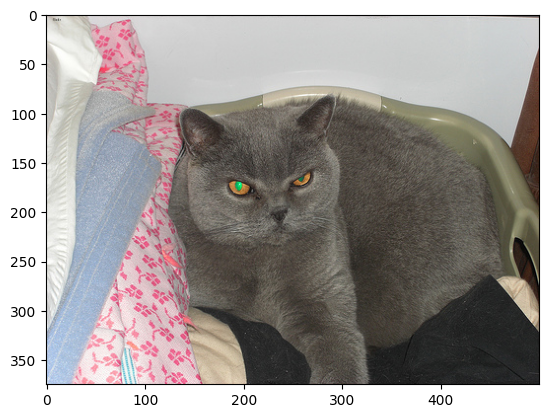

In [9]:
import cv2
img = cv2.imread(str(folder_path) + "/images/Cats_Test101.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(img.shape)
plt.imshow(img)

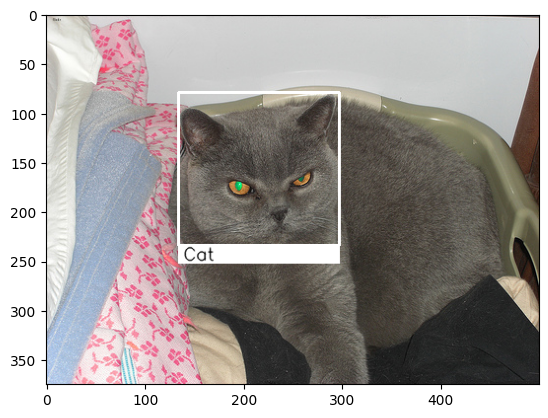

In [10]:
font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 0.8
color=(0,0,0)
thickness=1

img = cv2.rectangle(img, (xmin, ymin), (xmax,ymax), (255,255,255), 2)
img = cv2.rectangle(img,(xmin,ymax),(xmax,ymax+18),(255,255,255),-1)
img = cv2.putText(img,"Cat",(xmin+5,ymax+15),font,fontScale-0.2,color,thickness,cv2.LINE_AA)

plt.imshow(img)

Random image path: data/cat_dog/images/Cats_Test1001.png
Image height: 358
Image width: 500
Image shape: (500, 358)


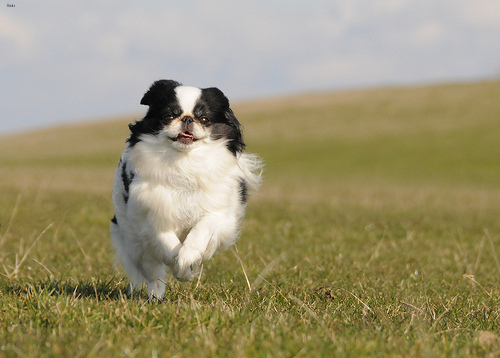

In [11]:
random_image_path = folder_path / "images" / "Cats_Test1001.png"
random_img = Image.open(random_image_path)
print(f"Random image path: {random_image_path}")
print(f"Image height: {random_img.height}")
print(f"Image width: {random_img.width}")
print(f"Image shape: {random_img.size}")
random_img

## 4 Preparing dataset
Converting `.xml` files to dataframes that can be used as dataset.

In [12]:
images = []
labels = []
bboxes = []
image_paths = []

for file in annotations:
  with open(os.path.join(directory,file), 'r') as f:
    content = f.read()

  data = BeautifulSoup(content, 'xml')

  filename = data.find("filename").text.strip()
  width = int(data.find("size").width.text)
  height = int(data.find("size").height.text)
  class_name = data.find("object").find("name").text
  xmin = float(data.find("object").find("bndbox").find("xmin").text) / width
  ymin = float(data.find("object").find("bndbox").find("ymin").text) / height
  xmax = float(data.find("object").find("bndbox").find("xmax").text) / width
  ymax = float(data.find("object").find("bndbox").find("ymax").text) / height

  image = cv2.imread(str(image_path) + '/' + filename)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image, (224, 224))

  images.append(image)
  labels.append(class_name)
  bboxes.append((xmin, ymin, xmax, ymax))
  image_paths.append(filename)

In [13]:
images = np.array(images, dtype="float32")
labels = np.array(labels)
bboxes = np.array(bboxes, dtype="float32")
image_paths = np.array(image_paths)

le = LabelEncoder()
labels = le.fit_transform(labels)

In [14]:
le.classes_

array(['cat', 'dog'], dtype='<U3')

In [20]:
le.inverse_transform([1])[0]

'dog'

In [15]:
split = train_test_split(images, labels, bboxes, image_paths, test_size=0.20,
                         random_state=42)

(trainImages, testImages) = split[:2]
(trainLabels, testLabels) = split[2:4]
(trainBBoxes, testBBoxes) = split[4:6]
(trainPaths, testPaths) = split[6:]

In [16]:
(trainImages, testImages) = torch.tensor(trainImages), torch.tensor(testImages)
(trainLabels, testLabels) = torch.tensor(trainLabels), torch.tensor(testLabels)
(trainBBoxes, testBBoxes) = torch.tensor(trainBBoxes), torch.tensor(testBBoxes)

In [21]:
# # %%writefile datasetgenerator.py
# """
# Contains DatasetGenrator and creates a dataset
# """

import torch
from torch.utils.data import Dataset
from typing import Tuple, Dict, List
import os
import pathlib
from PIL import Image

class CustomDatasetGenerator(Dataset):
  def __init__(self, tensors, transform=None):
    self.tensors = tensors
    self.transform = transform

  def __len__(self):
	  return len(self.tensors[0])

  def __getitem__(self, index):
    image = self.tensors[0][index]
    label = self.tensors[1][index]
    bbox = self.tensors[2][index]

    image = image.permute(2,0,1)
    if self.transform:
      image = self.transform(image)

    return (image, label, bbox)

## 5 Creating *Transforms* for training and testing dataset

In [22]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225],)
])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225],)
])

## 6 Creating `Dataset` and `DataLoader` fro our dataset

In [23]:
# from utils import CustomDatasetGenerator

train_data_custom = CustomDatasetGenerator((trainImages, trainLabels, trainBBoxes),
                                           transform=train_transform)
test_data_custom = CustomDatasetGenerator((testImages, testLabels, testBBoxes),
                                          transform=test_transform)
train_data_custom, test_data_custom

(<__main__.CustomDatasetGenerator at 0x79f80c2d79d0>,
 <__main__.CustomDatasetGenerator at 0x79f80c2d4e50>)

In [24]:
print(f"[INFO] total training samples: {len(train_data_custom)}")
print(f"[INFO] total test samples: {len(test_data_custom)}")

[INFO] total training samples: 2948
[INFO] total test samples: 738


In [25]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
PIN_MEMORY = True if device == "cuda" else False

In [26]:
train_dataloader = DataLoader(dataset=train_data_custom, # use custom created train Dataset
                              batch_size=BATCH_SIZE, # how many samples per batch?
                              num_workers=NUM_WORKERS, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True,
                              pin_memory=PIN_MEMORY) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data_custom,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                             shuffle=False,
                             pin_memory=PIN_MEMORY) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x79f80c2d4340>,
 <torch.utils.data.dataloader.DataLoader at 0x79f80c2d6380>)

### 6.1 Testing DataLoader

In [27]:
img, label, bbox = next(iter(train_dataloader))
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")
print(f"Bbox shape: {bbox.shape}")

Image shape: torch.Size([32, 3, 224, 224]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])
Bbox shape: torch.Size([32, 4])


torch.Size([224, 224, 3])


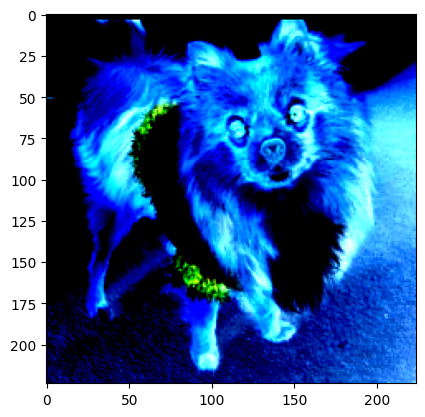

In [28]:
img = img[0].squeeze().permute(1,2,0)
print(img.shape)
plt.imshow(img)

In [29]:
# %%writefile objectdetector.py
# from torch import nn

class ObjectDetector(nn.Module):
  def __init__(self, baseModel, numClasses):
    super(ObjectDetector, self).__init__()
    self.baseModel = baseModel
    self.numClasses = numClasses

    # regressor layer
    self.regressor = nn.Sequential(
      nn.Linear(baseModel.fc.in_features, 128),
      nn.ReLU(),
      nn.Linear(128, 64),
      nn.ReLU(),
      nn.Linear(64, 32),
      nn.ReLU(),
      nn.Linear(32, 4),
      nn.Sigmoid()
    )

    # classification layer
    self.classifier = nn.Sequential(
      nn.Linear(baseModel.fc.in_features, 512),
      nn.ReLU(),
      nn.Dropout(p=0.2),
      nn.Linear(512, 512),
      nn.ReLU(),
      nn.Dropout(p=0.2),
      nn.Linear(512, self.numClasses)
    )

    # The final step is to make the base model’s fully connected layer into an
    # Identity layer, which means it’ll mirror the outputs produced by the
    # convolution block right before it
    self.baseModel.fc = nn.Identity()

  def forward(self, x):
    features = self.baseModel(x)
    bbox = self.regressor(features)
    classLogits = self.classifier(features)
    return bbox, classLogits

In [30]:
from typing import Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               class_loss_fn: torch.nn.Module,
               bbox_loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:

  # putting model in train mode
  model.train()

  # initialising train loss and accuracy
  train_loss, train_acc = 0, 0

  # loop through data loader data batches
  for batch, (X, y, bboxes) in enumerate(dataloader): # X=images, y=labels
      # Send data to target device
      X, y, bboxes = X.to(device), y.to(device), bboxes.to(device)

      bbox_pred, y_pred_logits = model(X)
      bbox_loss = bbox_loss_fn(bbox_pred, bboxes)
      class_loss = class_loss_fn(y_pred_logits, y)
      total_loss = bbox_loss + class_loss
      train_loss += total_loss.item()

      optimizer.zero_grad()
      total_loss.backward()
      optimizer.step()

      y_pred_class = torch.argmax(torch.softmax(y_pred_logits, dim=1), dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred_class)

  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [31]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              class_loss_fn: torch.nn.Module,
              bbox_loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:

  # Putting model to eval mode
  model.eval()

  # initialising test loss and accuracy
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
      # Loop through DataLoader batches
      for batch, (X, y, bboxes) in enumerate(dataloader):
        X, y, bboxes = X.to(device), y.to(device), bboxes.to(device)

        bbox_pred, test_pred_logits = model(X)
        bbox_loss = bbox_loss_fn(bbox_pred, bboxes)
        class_loss = class_loss_fn(test_pred_logits, y)
        total_loss = bbox_loss + class_loss
        test_loss += total_loss.item()

        test_pred_labels = test_pred_logits.argmax(dim=1)
        test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

In [32]:
from typing import Dict, List

from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          class_loss_fn: torch.nn.Module,
          bbox_loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List[float]]:

  # Create empty results dictionary
  results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
  }

  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
      train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          class_loss_fn=class_loss,
                                          bbox_loss_fn=bbox_loss,
                                          optimizer=optimizer,
                                          device=device)
      test_loss, test_acc = test_step(model=model,
                                          dataloader=test_dataloader,
                                          class_loss_fn=class_loss,
                                          bbox_loss_fn=bbox_loss,
                                          device=device)

      # Print out what's happening
      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
      )

      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)

  # Return the filled results at the end of the epochs
  return results

In [33]:
from pathlib import Path

def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):

  # Create target directory
  target_dir_path = Path(target_dir)
  target_dir_path.mkdir(parents=True, exist_ok=True)

  # Create model save path
  assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
  model_save_path = target_dir_path / model_name

  # Save the model state_dict()
  print(f"[INFO] Saving model to: {model_save_path}")
  torch.save(obj=model.state_dict(),
             f=model_save_path)

## 7 Initialising Model

In [34]:
weights = torchvision.models.ResNet50_Weights.DEFAULT
resnet = torchvision.models.resnet50(weights=weights)

for param in resnet.parameters():
	param.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 269MB/s]


In [35]:
resnet.fc.in_features

2048

In [36]:
# initialising our model
objectDetector = ObjectDetector(baseModel=resnet,
                                # in_features=resnet.fc.in_features,
                                numClasses=len(le.classes_))
summary(model=objectDetector,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
ObjectDetector (ObjectDetector)               [32, 3, 224, 224]    [32, 4]              --                   Partial
├─ResNet (baseModel)                          [32, 3, 224, 224]    [32, 2048]           --                   False
│    └─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
│    └─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
│    └─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
│    └─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
│    └─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56,

## 8 Training the Model

In [37]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 10

# initialising losses
class_loss = nn.CrossEntropyLoss()
bbox_loss = nn.MSELoss()

# optimizer
optim = torch.optim.Adam(params=objectDetector.parameters(), lr=1e-3)

# start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_results = train(model=objectDetector,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optim,
                        class_loss_fn=class_loss,
                        bbox_loss_fn=bbox_loss,
                        epochs=NUM_EPOCHS,
                        device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

# Save the model
save_model(model=objectDetector,
           target_dir="models",
           model_name="resnet_bbox_prediction_model.pth")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1988 | train_acc: 0.9227 | test_loss: 0.1013 | test_acc: 0.9688
Epoch: 2 | train_loss: 0.0921 | train_acc: 0.9745 | test_loss: 0.0826 | test_acc: 0.9779
Epoch: 3 | train_loss: 0.0592 | train_acc: 0.9835 | test_loss: 0.1257 | test_acc: 0.9648
Epoch: 4 | train_loss: 0.0656 | train_acc: 0.9829 | test_loss: 0.1081 | test_acc: 0.9727
Epoch: 5 | train_loss: 0.0552 | train_acc: 0.9862 | test_loss: 0.0877 | test_acc: 0.9779
Epoch: 6 | train_loss: 0.0614 | train_acc: 0.9812 | test_loss: 0.0991 | test_acc: 0.9701
Epoch: 7 | train_loss: 0.0352 | train_acc: 0.9929 | test_loss: 0.0868 | test_acc: 0.9753
Epoch: 8 | train_loss: 0.0435 | train_acc: 0.9879 | test_loss: 0.0816 | test_acc: 0.9766
Epoch: 9 | train_loss: 0.0436 | train_acc: 0.9889 | test_loss: 0.1005 | test_acc: 0.9727
Epoch: 10 | train_loss: 0.0278 | train_acc: 0.9943 | test_loss: 0.1145 | test_acc: 0.9727
[INFO] Total training time: 124.300 seconds
[INFO] Saving model to: models/resnet_bbox_prediction_model.pth


In [38]:
def plot_loss_curves(results):

  train_loss = results["train_loss"]
  test_loss = results["test_loss"]

  train_accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  epochs = range(len(results["train_loss"]))

  plt.figure(figsize=(15, 7))

  # Plot loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, train_loss, label="train_loss", color='b')
  plt.plot(epochs, test_loss, label="test_loss", color='r')
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, train_accuracy, label="train_accuracy", color='b')
  plt.plot(epochs, test_accuracy, label="test_accuracy", color='r')
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

### 8.1 Plotting the loss and accuracy curves

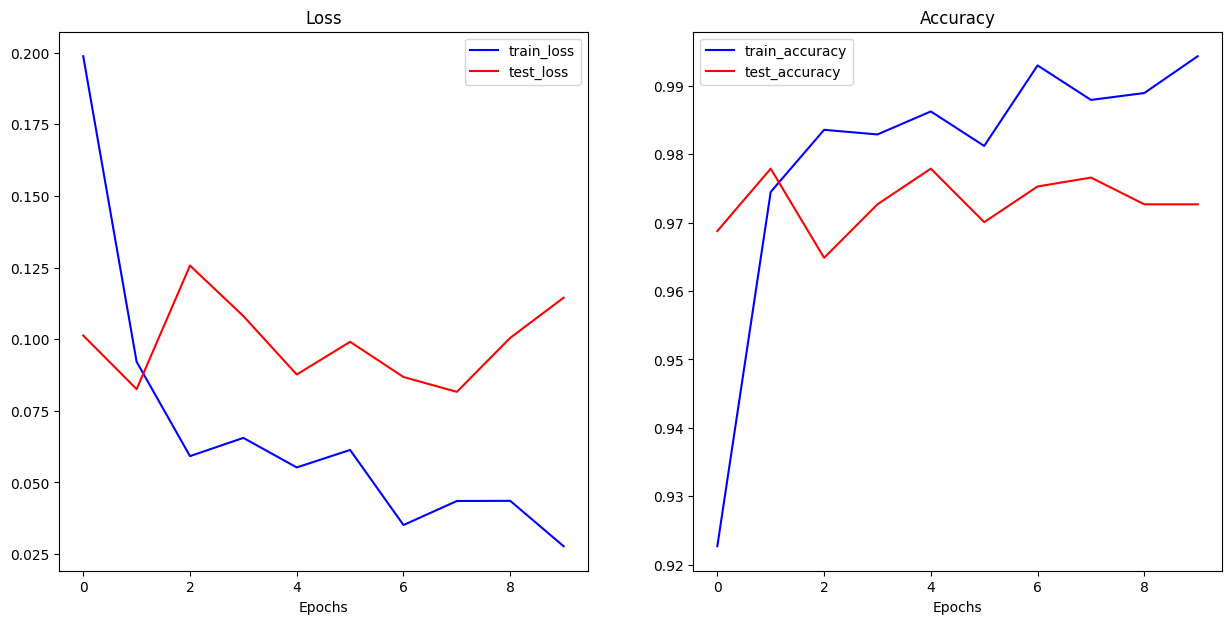

In [39]:
plot_loss_curves(model_results)

In [47]:
import requests
def download_random_img(data_path: str, image_link: str):
  """
  Takes in the image link and downloads it in the 'data_path'

  Args:
    image_link: link of teh image to be downloaded

  Returns:
    random_image_path: path of the downloaded image
  """

  random_image_path = data_path / "random_image.jpeg"
  if random_image_path.is_dir():
    print(f"{random_image_path} exists. Skipping Download")
  else:
    with open(random_image_path, "wb") as f:
      request = requests.get(image_link)
      print(f"Downloading image...")
      f.write(request.content)
      print(f"Image downloaded!")
  return random_image_path

In [83]:
# from timeit import default_timer as timer

def predict_random_img(data_path: str,
                      image_link: str,
                      model: torch.nn.Module,
                      le = None,
                      transform=None,
                      device: torch.device = device):
  """
  Downloads the image from the image link and infers the class of teh image
  with the probability of the prediction.

  Args:
    image_link: link of the image that you want to download ("image address")
    model: model with which prediction has to be done
    class_names: list of the possible categories for this classification
    transform: transformations needed for this image to be put inside the model
    device: "cuda" if available, otherwise "cpu"
  """
  # downloading the image
  image_filepath = download_random_img(data_path, image_link)
  print(f"random_image filepath: {image_filepath}")

  # reading the image
  image = cv2.imread(str(image_filepath))
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  h = image.shape[0]
  w = image.shape[1]

  image_resized = cv2.resize(image, (224, 224))
  image_resized = torch.tensor(image_resized)
  image_resized = image_resized.permute(2,0,1)
  image_transformed = transform(image_resized)

  # predicting the label and bbox
  model.to(device)
  start_time = timer()
  model.eval()
  with torch.inference_mode():
    image_transformed = image_transformed.unsqueeze(dim=0)
    bbox, label_logits = model(image_transformed.to(device))

  image_pred_probs = torch.softmax(label_logits, dim=1)
  target_image_pred_label = torch.argmax(image_pred_probs, dim=1)

  end_time = timer()
  print(f"[INFO] Total predicting time: {end_time-start_time:.3f} seconds")

  # Converting label code to label
  label = le.inverse_transform(target_image_pred_label.cpu())[0]
  title = f"{label} | {image_pred_probs.max()*100:.3f}%"

  # printing the image with the class and its probability
  # print(bbox)
  (xmin, ymin, xmax, ymax) = bbox[0]
  startX = int(xmin * w)
  startY = int(ymin * h)
  endX = int(xmax * w)
  endY = int(ymax * h)

  font = cv2.FONT_HERSHEY_SIMPLEX
  color = (0,0,0)
  if h < 1000 and w < 1000:
    fontScale = 0.8
    thickness = 2
  else:
    fontScale = 5
    thickness = 12

  image = cv2.rectangle(image, (startX,startY), (endX,endY), (255,255,255), 2)
  image = cv2.rectangle(image,(startX,endY),(endX,endY+int(0.05*h)),(255,255,255),-1)
  image = cv2.putText(image,title,(startX+int(0.02*w),endY+int(0.045*h)),font,fontScale-0.2,color,thickness,cv2.LINE_AA)

  plt.imshow(image)

## 9 Predicting the label for a random image

Image downloaded!
random_image filepath: data/random_image.jpeg
[INFO] Total predicting time: 0.018 seconds


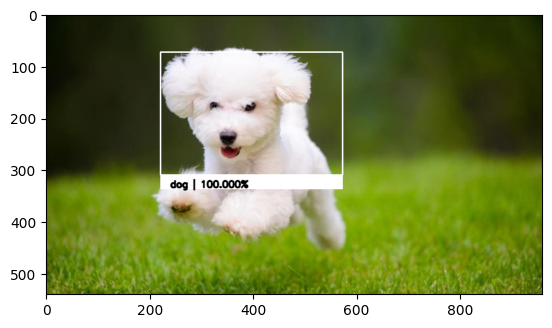

In [86]:
image_link = "https://thumbor.forbes.com/thumbor/fit-in/1290x/https://www.forbes.com/advisor/wp-content/uploads/2023/07/top-20-small-dog-breeds.jpeg.jpg"
predict_random_img(data_path=data_path,
                     image_link=image_link,
                     model=objectDetector,
                     le=le,
                     transform=test_transform,
                     device=device)